- [imports](#imports)
- [settings](#settings)
- [data](#data)
- [methodology](#methodology)
- [results](#results)
    - [probability](#prob)
    - [variance](#mfiv)

# imports

In [1]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings  # suppress warnings
from pathlib import Path

# project
from config import *
from src.visuals import *

# settings

In [2]:
DATA_PATH = Path("data")  # assumes this notebook is run from root
MATURITY = 1/12  # maturity (approx) of options in the dataset, in years

plt.style.use("seaborn-v0_8-colorblind")

# matplotlib
palette = plt.rcParams['axes.prop_cycle'].by_key()['color']

# suppress warnings
warnings.filterwarnings('ignore')

# data

In [3]:
data = pd.read_feather(DATA_PATH / "processed" / "data.ftr")

# print example
data.query(f"date == '{min(data['date'])}'")\
    .style.format(precision=4)

,date,contract,value
0,2021-12-31 09:00:00+01:00,forward,75.3916
57307,2021-12-31 09:00:00+01:00,r_base,0.0008
114614,2021-12-31 09:00:00+01:00,spot,74.8688
171921,2021-12-31 09:00:00+01:00,v_10b,0.0225
229228,2021-12-31 09:00:00+01:00,v_10r,0.0827
286535,2021-12-31 09:00:00+01:00,v_25b,0.0052
343842,2021-12-31 09:00:00+01:00,v_25r,0.0384
401149,2021-12-31 09:00:00+01:00,v_atm,0.1399
458456,2021-12-31 09:00:00+01:00,r_counter,0.0812


## events

Events and their timestamps (GMT+1) are from Bloomberg.

In [4]:
# load events data
data_events = pd.read_csv(DATA_PATH / "raw" / "timeline.csv",
                          index_col=0)
date_t = data_events.index[-1]  # announcement of invasion

data_events.style.format()

,event
date,
02/24/2022 04:06:03+01:00,putin announces special military operation
02/18/2022 22:58:43+01:00,biden warns russia is planning attack in coming days
02/17/2022 15:19:39+01:00,biden estimates prob of invasion as very high
02/11/2022 20:03:18+01:00,jake sullivan believes putin has decided to invade next week
02/11/2022 11:34:58+01:00,blinken warns russia can attack during the olympics


## spot
Spot quotes of USDRUB at 1-min frequency (GMT+1 time) are from Bloomberg.

In [5]:
# load spot data
data_spot = data.query("contract == 'spot'").drop("contract", axis=1)

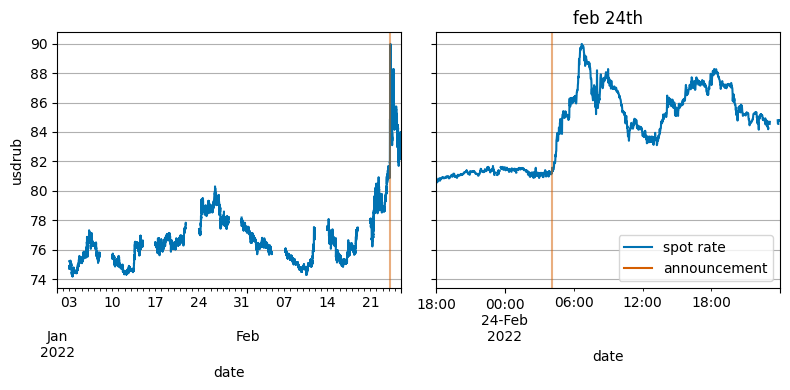

In [6]:
# plot spot exchange rate dynamics
plot_spot(data_spot.set_index("date").squeeze())
plt.show()

## forward
1-month forward quotes are from Bloomberg:

In [7]:
# load forward data
data_forward = data.query("contract == 'forward'").drop("contract", axis=1)

## rates
USD rates are 1-month OIS rates; RUB rates are implied from the covered interest rate parity for USDRUB:
$$ F = S \times \frac{1 + r_{rub}}{1 + r_{usd}} $$

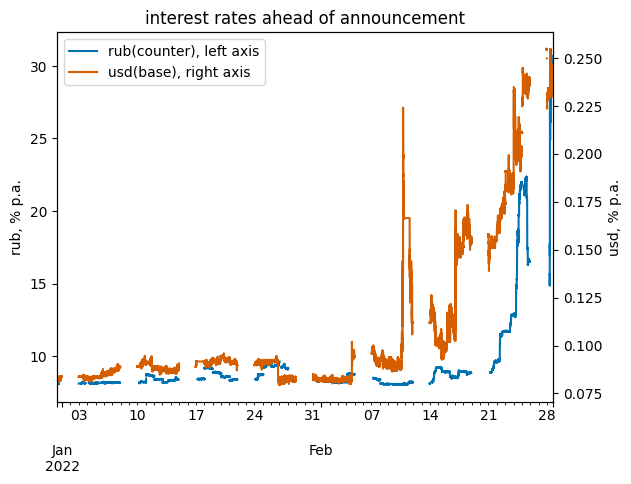

In [8]:
# interest rates data: 'rf' for the RUB rate, 'div_yield' for the USD rate.
data_rates = data.query("contract in ('r_base', 'r_counter')")\
    .pivot(index="date", columns="contract", values="value")

plot_rates(data_rates * 100)
plt.show()

## option contracts

FX options are quoted in terms of implied volatilities (henceforth "IV") of "at-the-money" contracts, as well as 10- and 25-delta "butterfly spreads" (aka "market strangles") and "risk reversals". The exact definitions of these differ between currency pairs, and I refer the reader to the excellent book ["Foreign Exchange Option Pricing: A Practitioner's Guide"](https://books.google.ch/books?id=7vua-0-2sgMC&redir_esc=y) by Iain Clark for further details. In what follows, `v_atm` references the at-the-money IV, `v_10b` (`v_25b`) &mdash; the IV of the 10-delta (25-delta) market strangle and `v_10r` (`v_25r`) &mdash; the IV of the 10-delta (25-delta) risk reversal. All IV values are in fractions of 1 per annum.

In [9]:
# option contracts data
data_opt = data.loc[data["contract"].str.startswith("v_")]\
    .pivot(index="date", columns="contract", values="value")

format_dataframe(data_opt.dropna().tail(), precision=4)

date,v_10b,v_10r,v_25b,v_25r,v_atm
2022-02-28 16:27,0.1460,0.4581,0.0377,0.2122,0.8563
2022-02-28 16:30,0.1461,0.4584,0.0377,0.2123,0.8563
2022-02-28 16:32,0.1462,0.4587,0.0377,0.2124,0.8563
2022-02-28 16:36,0.1463,0.4593,0.0377,0.2127,0.8563
2022-02-28 16:44,0.1467,0.4603,0.0377,0.2132,0.8548


# methodology

## risk-neutral probability
To estimate the probability of the spot rate exceeding a certain threshold, I integrate the risk-neutral density of the spot rate extracted non-parametrically over a suitable domain.

The well-known result from [Breeden and Litzenberger (1978)](https://www.jstor.org/stable/2352653?seq=1#metadata_info_tab_contents) equates the risk-neutral density of the underlying $q(S)$ to the second derivative of the option pricing function $C(\cdot)$ w.r.t. the strike price $K$:
$$q(S) = e^{r_f \tau} \frac{\partial^2 C(S,K,\ldots)}{\partial K^2}.$$
With a pricing function at hand, numerical calculation of the density is straighforward. Here, I take $C$ to be the Black-Scholes pricing function at the level of SABR-derived implied volatilities along the strike dimension:
$$C(S, K), \ldots = C^{bs}(S, \hat{\sigma}(K), K, \ldots),$$
where $\hat{\sigma}(K)$ is the SABR volatility smile calibrated to the FX option contracts (details in the [data section](#data)).

## risk-neutral variance
tbd

# results

I present only the results of the calculations here. A detailed walkthrough is postponed to the [appendix](#walkthrough).

## risk-neutral probability <a name="prob"></a>

In [9]:
# non-parametric density, integrated from different levels upwards
fname = "output/estimates/prob-nonparam.csv"
prob = pd.read_csv(fname, index_col=0, parse_dates=True)\
    .rename(columns=int)

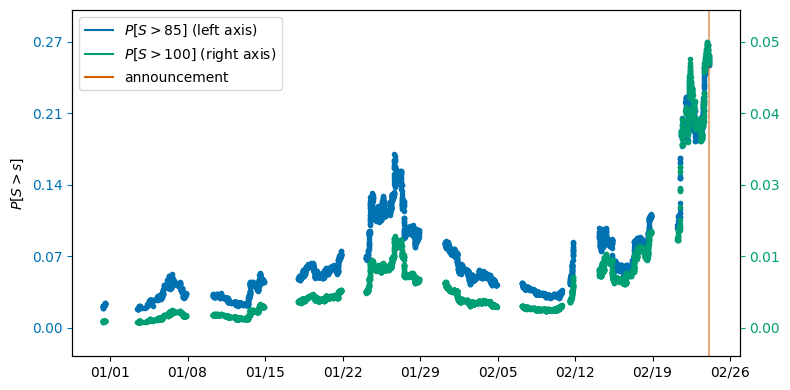

In [10]:
plot_invasion_probability(prob.loc[:dt_t], plot_warnings=False)
plt.show()

Next, I check how this probability changed in response to the forebodings of US officials. In total, there were 4 of them, as listed in the [data section](#events).

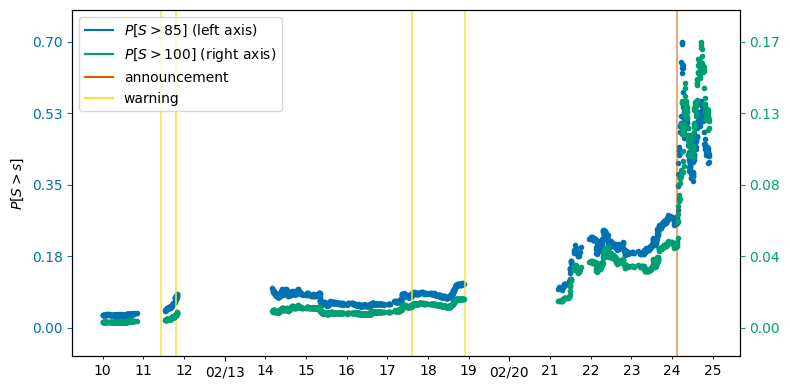

In [11]:
plot_invasion_probability(prob.loc["2022-02-10":"2022-02-24"], plot_warnings=True)
plt.show()

## risk-neutral variance of USDRUB <a name="mfiv"></a>

Finally, I estimate the forward-looking variance of USDRUB around the invasion using the standard result discussed i.a. in [Carr and Madan (2002)](http://pricing.online.fr/docs/TradingVolatilityStrat.pdf):

In [12]:
fname = "output/estimates/mfiv-nonparam.csv"
mfiv = pd.read_csv(fname, index_col=0, parse_dates=True)\
    .squeeze()

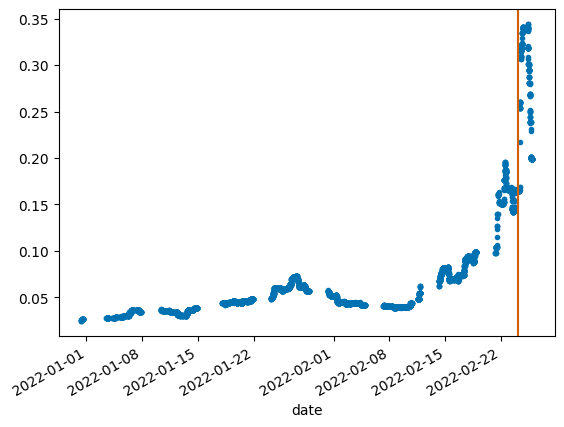

In [13]:
ax = mfiv.loc[:"2022-02-25"].plot(linestyle="none", marker=".")
ax.axvline(x=dt_t, color=palette[2])
plt.show()

Consistent with the previous results, the variance of the USDRUB returns went up over the course of a week before the invasion and further jumped up immediately after it.